# Carvana Image Masking Challenge

#### Segmentation of images using U-Net Convolutional Neural Network

### Import Statements

In [1]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from keras.models import Model
from os.path import join
from os import listdir
from keras.preprocessing import image
import os
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (20, 20)

Using TensorFlow backend.


### Constants

In [2]:
DATA_DIR = join(os.getcwd(), 'data')
TRAIN_DIR = join(DATA_DIR, 'train')
MASK_DIR = join(DATA_DIR, 'train_masks')
TRAIN_IMAGE_LIST = listdir(TRAIN_DIR)
MASK_IMAGE_LIST = listdir(MASK_DIR)
ASPECT_RATIO = 1280 / 1918

### Splitting the data

In [3]:
train_images, test_images, train_masks, test_masks = train_test_split(TRAIN_IMAGE_LIST, MASK_IMAGE_LIST, test_size=0.2)

### Data Augumentation 

In [4]:
def recreate_image(codebook, labels, w, h):
    '''
    Recreate the (compressed) image from the code book & labels
    '''
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

In [5]:
def random_flip(img,mask, u=0.5):
    if np.random.random() < u:
        img = np.flip(img, 1)
        mask = np.flip(mask, 1)
    return img, mask

In [6]:
def rotate(x, theta, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(rotation_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_rotate(img,mask, rotate_limit=(-20, 20), u=0.5):
    if np.random.random() < u:
        theta = np.pi / 180 * np.random.uniform(rotate_limit[0], rotate_limit[1])
        img = rotate(img, theta)
        mask = rotate(mask, theta)
    return img, mask

In [7]:
def shift(x, wshift, hshift, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = hshift * h
    ty = wshift * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])
    transform_matrix = translation_matrix  # no need to do offset
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_shift(img, mask, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.5):
    if np.random.random() < u:
        wshift = np.random.uniform(w_limit[0], w_limit[1])
        hshift = np.random.uniform(h_limit[0], h_limit[1])
        img = shift(img, wshift, hshift)
        mask = shift(mask, wshift, hshift)
    return img, mask

In [8]:
def zoom(x, zx, zy, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(zoom_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_zoom(img,mask, zoom_range=(0.8, 1), u=0.5):
    if np.random.random() < u:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
        img = zoom(img, zx, zy)
        mask = zoom(mask, zx, zy)
    return img, mask

In [9]:
def shear(x, shear, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(shear_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_shear(img, mask, intensity_range=(-0.5, 0.5), u=0.5):
    if np.random.random() < u:
        sh = np.random.uniform(-intensity_range[0], intensity_range[1])
        img = shear(img, sh)
        mask = shear(mask, sh)
    return img,mask

In [10]:
def all_aug(img, mask, flip_chance=0, rotate_chance=0,rotate_limit=(-20,20), shift_chance=0, 
            shift_limit_w=(-0.1, 0.1), shift_limit_h=(-0.1, 0.1), zoom_chance=0, zoom_range=(0.8, 1), 
            shear_chance=0, shear_range=(-0.5, 0.5)):

    new_img = np.empty_like(img)
    new_mask = np.empty_like(mask)
    
    for ind in range(img.shape[0]):
        
        new_img[ind,:,:,:],new_mask[ind,:,:,:] = random_flip(img[ind], mask[ind], u=flip_chance)

        new_img[ind,:,:,:],new_mask[ind,:,:,:] = random_rotate(new_img[ind], new_mask[ind], rotate_limit=rotate_limit, u=rotate_chance)

        new_img[ind,:,:,:],new_mask[ind,:,:,:] = random_shift(new_img[ind], new_mask[ind], w_limit = shift_limit_w, h_limit=shift_limit_h, u=shift_chance)

        new_img[ind,:,:,:],new_mask[ind,:,:,:] = random_zoom(new_img[ind], new_mask[ind], zoom_range=zoom_range, u=zoom_chance)

        new_img[ind,:,:,:],new_mask[ind,:,:,:] = random_shear(new_img[ind], new_mask[ind], intensity_range=shear_range, u=shear_chance)

    return new_img,new_mask

In [11]:
def color_quantize(img, target_colors):
    '''
    img: Source Image to perform Color Quantization.
    target_colors: The number of bit of colors to quantize.
    '''
    img = img_to_array(img)
    image_array = np.reshape(img, (img.shape[0] * img.shape[1], img.shape[2]))
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters=target_colors, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    return recreate_image(kmeans.cluster_centers_, labels, img.shape[0], img.shape[1])

In [12]:
def image_generator_function(images, masks, batch_size, img_width = None, num_colors = 256):
    
    '''
    images: Array of image names
    masks: Array of mask names
    batch_size: The number of images to be consider in one batch.
    num_colors = target number of colors for kmeans algorithm. (Default = 256)
    img_width: The width to which the original image is resized while maintaining aspect ratio. Does not resize if no parameters passed.
    '''
    
    img_dim = [int(ASPECT_RATIO * img_width), img_width] if img_width is not None else None
    
    while True:
        
        random_indices = np.random.choice(len(images), batch_size)
        
        imgs = [img_to_array(color_quantize(load_img(join(TRAIN_DIR, images[index]), target_size = img_dim), num_colors)) / 255 for index in random_indices]
        
        masks = [img_to_array(load_img(join(MASK_DIR, masks[index]), target_size = img_dim)) / 255 for index in random_indices]
        
        yield np.array(imgs), np.array(masks)

In [13]:
train_generator = image_generator_function(train_images, train_masks, 5, 500, 16)
img_tmp, mask_tmp = next(train_generator)
img, mask = all_aug(img_tmp,mask_tmp,flip_chance=0.1, rotate_chance=0.1,rotate_limit=(-30,30), shift_chance=0.1, 
           shift_limit_w=(-0.1, 0.1), shift_limit_h=(-0.1, 0.1), zoom_chance=0.1, zoom_range=(0.8, 1), 
            shear_chance=0, shear_range=(-0.5, 0.5))

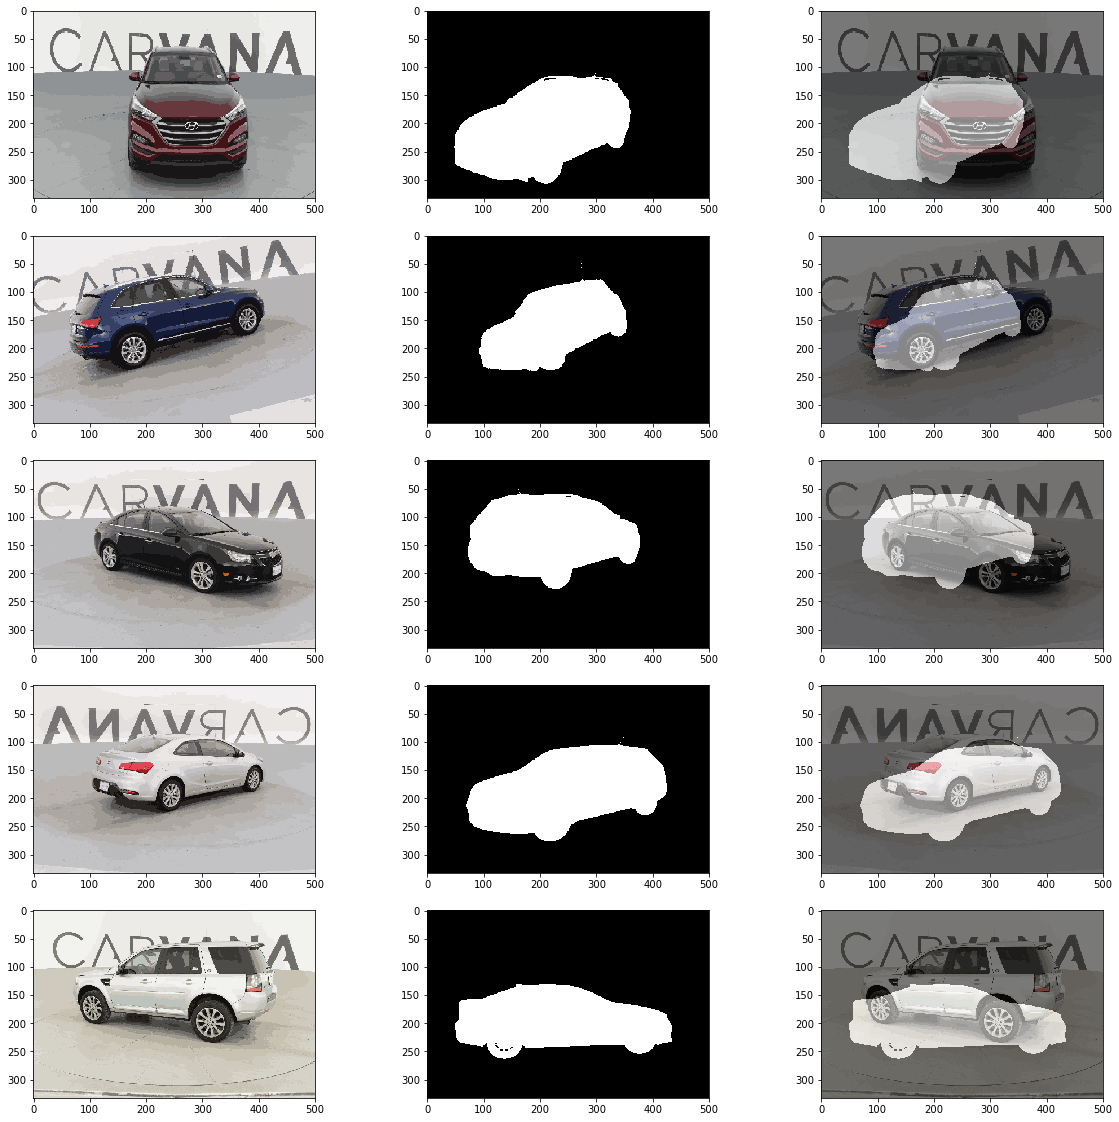

In [14]:
plot = 1
for i in range(img.shape[0]):
    plt.subplot(img.shape[0], 3, plot)
    plt.imshow(img[i])
    plot += 1
    plt.subplot(img.shape[0], 3, plot)
    plt.imshow(mask[i])
    plot += 1
    plt.subplot(img.shape[0], 3, plot)
    plt.imshow(img[i])
    plt.imshow(mask[i], alpha=0.5)
    plot += 1
plt.show()

In [15]:
def get_conv_layer_with_dropout(filter_size, input_layer, mask_shape=(3, 3), dropout_rate=0.2, dropout=True):
    conv2d = Conv2D(filter_size, mask_shape, padding='same', activation='relu')(input_layer)
    if dropout:
        return Dropout(dropout_rate)(conv2d)
    else:
        return conv2d

In [18]:
def dice_coef(y_true, y_pred):
    
    intersect = 2 * y_true * y_pred
    
    len_true = sqrt(sum((y_true)**2))
    
    len_pred = sqrt(sum((y_pred)**2))
    
    loss = intersect/(len_true+len_pred)
    
    return loss

In [25]:
def get_unet_model(input_shape):
    # Input layer
    input_layer = Input(shape=input_shape)
    # Down 1
    down_conv_1 = get_conv_layer_with_dropout(64, input_layer)
    residual_1 = get_conv_layer_with_dropout(64, down_conv_1, dropout=False)
    maxpool_1 = MaxPooling2D()(residual_1)
    # Down 2
    down_conv_2 = get_conv_layer_with_dropout(128, maxpool_1)
    residual_2 = get_conv_layer_with_dropout(128, down_conv_2, dropout=False)
    maxpool_2 = MaxPooling2D()(residual_2)
    # Down 3
    down_conv_3 = get_conv_layer_with_dropout(256, maxpool_2)
    residual_3 = get_conv_layer_with_dropout(256, down_conv_3, dropout=False)
    maxpool_3 = MaxPooling2D()(residual_3)
    # Down 4
    down_conv_4 = get_conv_layer_with_dropout(512, maxpool_3)
    residual_4 = get_conv_layer_with_dropout(512, down_conv_4, dropout=False)
    maxpool_4 = MaxPooling2D()(residual_4)
    # Flat
    flat_conv = get_conv_layer_with_dropout(1024, maxpool_4)
    residual_flat = get_conv_layer_with_dropout(1024, flat_conv, dropout=False)
    # Up 1
    upsample_1 = UpSampling2D()(residual_flat)
    concat_1 = Concatenate(axis=3)([residual_4, upsample_1])
    up_conv_1d = get_conv_layer_with_dropout(512, concat_1)
    up_conv_1 = get_conv_layer_with_dropout(512, up_conv_1d, dropout=False)
    # Up 2
    upsample_2 = UpSampling2D()(up_conv_1)
    concat_2 = Concatenate(axis=3)([residual_3, upsample_2])
    up_conv_2d = get_conv_layer_with_dropout(256, concat_2)
    up_conv_2 = get_conv_layer_with_dropout(256, up_conv_2d, dropout=False)
    # Up 3
    upsample_3 = UpSampling2D()(up_conv_2)
    concat_3 = Concatenate(axis=3)([residual_2, upsample_3])
    up_conv_3d = get_conv_layer_with_dropout(128, concat_3)
    up_conv_3 = get_conv_layer_with_dropout(128, up_conv_3d, dropout=False)
    # Up 4
    upsample_4 = UpSampling2D()(up_conv_3)
    concat_4 = Concatenate(axis=3)([residual_1, upsample_4])
    up_conv_4d = get_conv_layer_with_dropout(64, concat_4)
    up_conv_4 = get_conv_layer_with_dropout(64, up_conv_4d, dropout=False)
    # Output layer
    output_layer = out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up_conv_4)

    # Create Model
    model = Model(input_layer, output_layer)
    return model

In [26]:
model = get_unet_model([128, 128, 3])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_77 (Conv2D)               (None, 128, 128, 64)  1792        input_5[0][0]                    
____________________________________________________________________________________________________
dropout_37 (Dropout)             (None, 128, 128, 64)  0           conv2d_77[0][0]                  
____________________________________________________________________________________________________
conv2d_78 (Conv2D)               (None, 128, 128, 64)  36928       dropout_37[0][0]                 
___________________________________________________________________________________________